In [3]:
import numpy as np
import pandas as pd
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import shutil

from brats_competition.preprocessing.preprocess import read_instance, CHANNELS
from brats_competition.definitions import PREPROCESSING_CONFIG_PATH
sns.set()

In [4]:
with open(PREPROCESSING_CONFIG_PATH, "r") as config_file:
    config = yaml.full_load(config_file)

In [5]:
images_paths = glob.glob(os.path.join(config["preprocessed_path"], "train_3d", "*"))
images_paths.sort()

### Explore distribution of background

In [20]:
nonzero_pixels = []
for path in tqdm.tqdm(images_paths):
    _, y = read_instance(path)
    nonzero_pixels.extend((y != 0).mean(axis=(0, 1)))

100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [05:00<00:00,  1.06s/it]


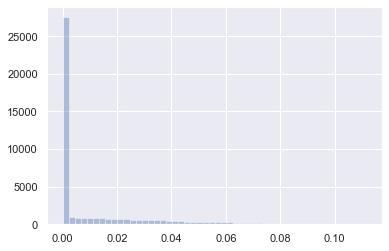

In [21]:
sns.distplot(nonzero_pixels, kde=False)

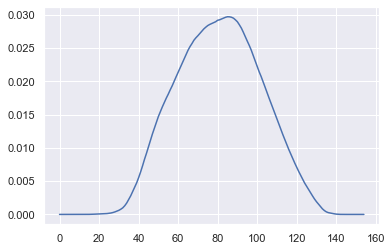

In [22]:
depth = y.shape[-1]
df = pd.DataFrame([nonzero_pixels[i * depth: (i + 1) * depth] for i in range(len(nonzero_pixels) // depth)])
df.apply(lambda x: x.mean()).plot()

### Mean and standart deviation calculation

In [6]:
means = np.zeros(len(CHANNELS))
stds = np.zeros(len(CHANNELS))

for path in tqdm.tqdm(images_paths):
    X, _ = read_instance(path)
    means += X.mean(axis=(1, 2, 3))
    stds += (X ** 2).mean(axis=(1, 2, 3))

means /= len(images_paths)
stds /= len(images_paths)
stds = np.sqrt(stds - means ** 2)

100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [06:24<00:00,  1.35s/it]


In [13]:
for channel_name, mean, std in zip(CHANNELS, means, stds):
    print(f"Channel: {channel_name}; Mean: {mean}; Std: {std}")

Channel: flair; Mean: 69.93894844791195; Std: 565.1511879415906
Channel: t1; Mean: 95.63922359273246; Std: 524.8499357125821
Channel: t1ce; Mean: 106.9682677196129; Std: 541.5877023933664
Channel: t2; Mean: 109.37320936782201; Std: 616.0813493117512


### Compute labels frequencies

In [6]:
images_2d_paths = glob.glob(os.path.join(config["preprocessed_path"], "train_2d", "y", "*"))

labels_number = 4
frequencies_2d = np.zeros(labels_number)

for path in tqdm.tqdm(images_2d_paths):
    y = np.load(path)
    unique, fr = np.unique(y, return_counts=True)
    unique[unique == 4] = 3
    frequencies_2d[unique] += fr

weights_2d = frequencies_2d.sum() / frequencies_2d
weights_2d /= weights_2d.sum()
weights_2d

0it [00:00, ?it/s]
/home/andriiprysiazhnyk/Documents/ucu/ml/project/env/lib64/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


array([nan, nan, nan, nan])

In [7]:
frequencies_3d = np.zeros(labels_number)

for path in tqdm.tqdm(images_paths):
    _, y = read_instance(path)
    y = y.astype(np.uint8)
    unique, fr = np.unique(y, return_counts=True)
    unique[unique == 4] = 3
    frequencies_3d[unique] += fr

weights_3d = frequencies_3d.sum() / frequencies_3d
weights_3d /= weights_3d.sum()
weights_3d

0it [00:00, ?it/s]
/home/andriiprysiazhnyk/Documents/ucu/ml/project/env/lib64/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


array([nan, nan, nan, nan])

### Plot some examples

In [4]:
image, segmentation = read_instance(images_paths[100])

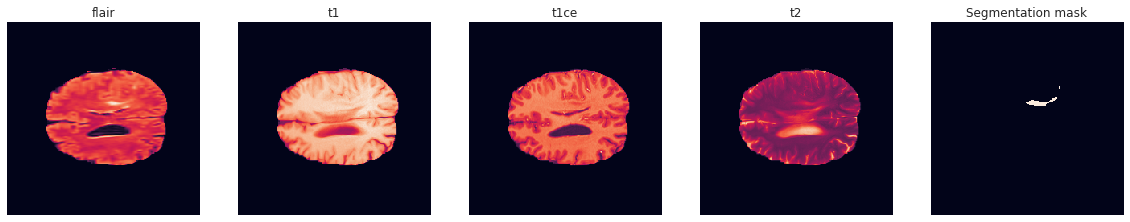

In [15]:
plot_image_slice(image, segmentation, 100)

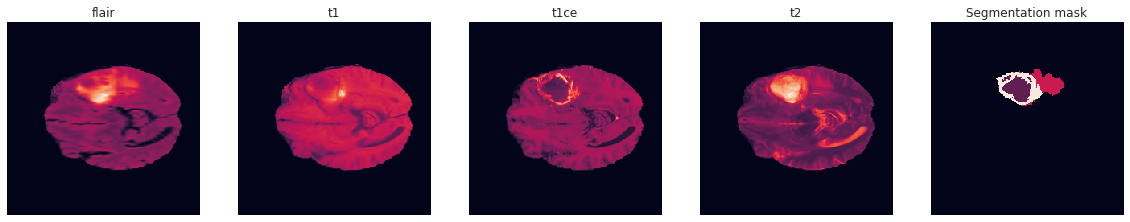

In [16]:
plot_image_slice(image, segmentation, 65)

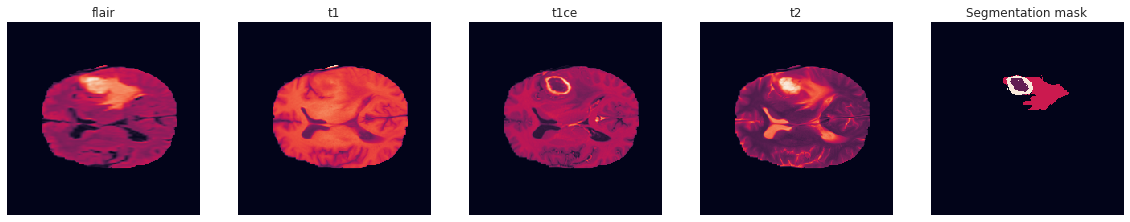

In [17]:
plot_image_slice(image, segmentation, 80)

### Plot average image

In [43]:
mean_slice = np.zeros(image.shape[:-1])
mean_mask = np.zeros(segmentation.shape[:-1])
SLICE = 100

for path in tqdm.tqdm(images_paths):
    X, y = read_instance(path)
    mean_slice += X[:, :, :, SLICE]
    mean_mask += y[:, :, SLICE]

mean_slice, mean_mask = mean_slice / len(images_paths), mean_mask / len(images_paths)

100%|██████████| 335/335 [02:35<00:00,  2.15it/s]


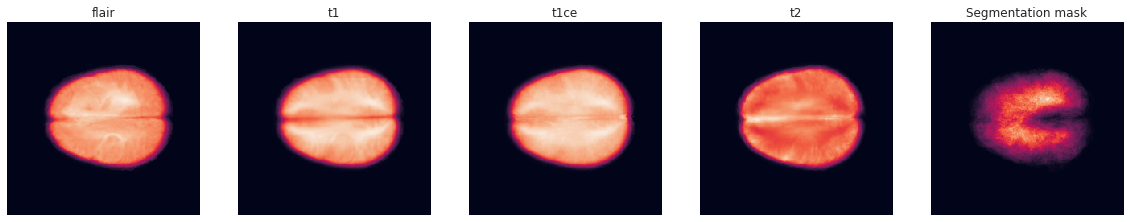

In [52]:
plot_image_slice(mean_slice.reshape(*mean_slice.shape, 1), mean_mask.reshape(*mean_mask.shape, 1), 0)